In [1]:
from __future__ import division, print_function, unicode_literals
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from CapsLayer import squash,margin_loss,safe_norm,bridge,log_loss,conv_to_caps,capsule,caps_to_conv
import json
tf.reset_default_graph()
from data import gen_data

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
input_dim = [28,28]

X = tf.placeholder(shape=[None, input_dim[0],input_dim[1], 1], dtype=tf.float32, name="X")
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")


In [3]:
caps1_n_maps =16
caps1_n_dims = 4
num_classes =10

In [4]:

conv1 = tf.layers.conv2d(X, name="conv1", filters = 256, 
                         kernel_size = 9,strides = 1,padding = "valid", activation = tf.nn.relu)
conv2 = tf.layers.conv2d(conv1, name="conv2", filters = caps1_n_maps * caps1_n_dims,
                         kernel_size = 9,strides = 2, padding = "valid",activation = tf.nn.relu)

caps1_n_caps = caps1_n_maps * conv2.get_shape().as_list()[1]  * conv2.get_shape().as_list()[2] 

print(caps1_n_caps)


576


In [5]:

init_sigma = 1


conv2 = [conv2,caps1_n_caps,caps1_n_dims]
caps2_output = capsule(conv2,num_caps=512,caps_dims=4,
                           batch_size=tf.shape(X)[0],init_sigma = init_sigma,name = "caps2")

conv3 = tf.layers.conv2d(caps_to_conv(caps2_output), name="conv3", filters = 128,
                         kernel_size = 1,strides = 1, padding = "valid",activation = tf.nn.relu)


conv4 = conv_to_caps(conv3,num_maps=8,caps_dims=4,kernel_size = 2,name="conv4")

caps3_output = capsule(conv4,num_caps=10,caps_dims=4,
                        batch_size=tf.shape(X)[0],init_sigma = init_sigma,name = "caps3")

output = caps3_output

print("kk")

kk


In [6]:
print(conv3)

Tensor("conv3/Relu:0", shape=(?, 512, 4, 128), dtype=float32)


In [7]:
y_proba = safe_norm(output[0], axis=-2, name="y_proba")
y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")
y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")

In [8]:
loss = margin_loss(output[0],num_classes,y)
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
training_op = optimizer.minimize(loss, name="training_op")


init = tf.global_variables_initializer()
saver = tf.train.Saver()

Tensor("absent_error:0", shape=(?, 10), dtype=float32)


Starting training MNIST


<IPython.core.display.Javascript object>


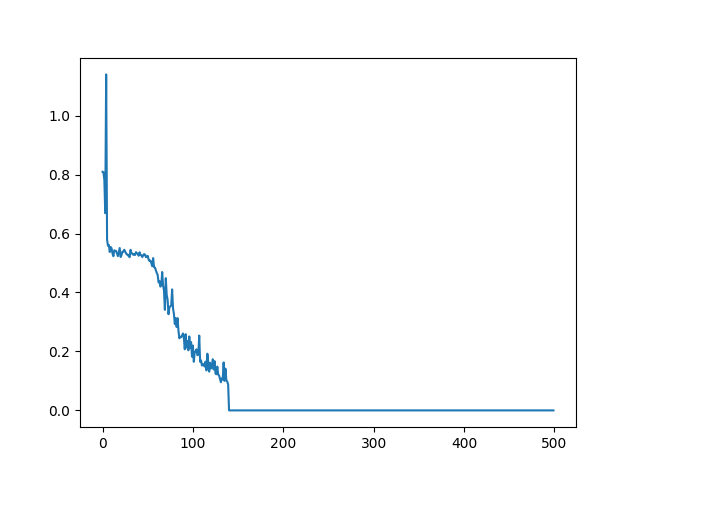

Iteration: 140/500 (28.0%)  Loss: 0.08783  predicted : [5 1 2 9 2]  real : [5 1 2 9 2]

KeyboardInterrupt: 

In [9]:
MNIST = True
print("Starting training MNIST")
n_epochs = 10
batch_size = 50

if not MNIST:
    data = gen_data(batch_size=batch_size)
    n_iterations_per_epoch = 1600 // batch_size
    print("Done loading Data")
else:
    n_iterations_per_epoch = mnist.train.num_examples // batch_size
    n_iterations_per_epoch=500

restore_checkpoint = True

n_iterations_validation = 300#mnist.train.num_examples // batch_size

best_loss_val = np.infty
checkpoint_path = "./my_capsule_network"

with tf.Session() as sess:
    save=False
    if save:
        if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
            saver.restore(sess, checkpoint_path)
        else:
            init.run()
    else:
        init.run()
    
    predicted = ""
    for epoch in range(n_epochs):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.ion()
        #fig.show()
        fig.canvas.draw()
        data = gen_data(batch_size=batch_size)
        loss_data = np.zeros([n_iterations_per_epoch])
        for iteration in range(1, n_iterations_per_epoch + 1):
            
            if MNIST:
                X_batch, y_batch = mnist.train.next_batch(batch_size)
                X_batch = X_batch.reshape([-1, 28, 28, 1])
            else:
                try:
                    band1,band2,y_batch = next(data)
                except StopIteration:
                    break
                X_batch = np.concatenate([band1,band2],axis=1)
            _, loss_train,pred,real,proba = sess.run(
                [training_op, loss,y_pred,y,y_proba],
                feed_dict={X: X_batch,
                           y: y_batch})
                           #mask_with_labels: True})
            if(iteration % 10 == 0):
                predicted = "  predicted : {}  real : {}".format(pred[0:5],real[0:5])#proba[0][0])
            print(("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}"+predicted).format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")
            loss_data[iteration-1] = loss_train
            
            
            ax.clear()
            ax.plot(loss_data)
            fig.canvas.draw()

        if not MNIST:
            data = gen_data(batch_size=1)
        
        
        #plt.plot(loss_data)
        plt.ioff()
        plt.show()
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            if MNIST:
                X_batch, y_batch = mnist.train.next_batch(batch_size)
                X_batch = X_batch.reshape([-1, 28, 28, 1])
            else:
                try:
                    band1,band2,y_batch = next(data)
                except StopIteration:
                    break
                X_batch = np.concatenate([band1,band2],axis=1)
            
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, input_dim[0], input_dim[1], 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val and save:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val